## Data Loading and Preprocessing

In [1]:
# Extend system path to include 'Scripts' and 'Utilities' directories for module imports
import sys
sys.path.extend(['../Scripts', '../Utilities'])

In [2]:
# Importing general utility functions from the 'import_libraries' module
from import_libraries import get_general_utils, get_data_handling_and_viz_libs

# Get data handling
np, plt, sns, cv2 = get_data_handling_and_viz_libs()

# Getting the Path and os modules from the general utilities
Path, os = get_general_utils()

# Setting the path to the dataset. 
dataset_path = Path("/Users/rajesh/Desktop/CNN-Predictor-for-Malaria_Cells-LIME-CAM-main/cell_images")


In [3]:
# Import Image Processing utilities
from image_processing import load_and_preprocess_images

# Define constants
SIZE = 64
COLOR_MODE = 'rgb'  

# Initialize lists for dataset and labels
infected_data, infected_labels = load_and_preprocess_images(dataset_path/'Parasitized', SIZE, COLOR_MODE)
uninfected_data, uninfected_labels   = load_and_preprocess_images(dataset_path/'Uninfected' , SIZE, COLOR_MODE)

# Combine the datasets and labels
dataset = infected_data   + uninfected_data
labels  = infected_labels + uninfected_labels

# Display basic statistics
print(f"Total images: {len(dataset)}")
print(f"Number of 'Infected' images: {len(infected_data)}")
print(f"Number of 'Uninfected' images:  {len(uninfected_data)}")

Total images: 27558
Number of 'Infected' images: 13779
Number of 'Uninfected' images:  13779


---
---

## Model Building

In this section, we focus on constructing and compiling our Convolutional Neural Network (CNN) model for the task of classifying malaria-infected cells. The process involves two primary stages:

- **Model Architecture**: We outline the architecture of our CNN, carefully detailing each layer, its type, and the connectivity amongst them. A standout feature of our model is the incorporation of a Global Average Pooling (GAP) layer, which not only contributes to reducing the model's complexity but also facilitates the extraction of spatial hierarchies of features crucial for anomaly localization. The choice of architecture is instrumental, as it directly influences the model's ability to discern and learn from the intricate patterns present in our image data.

- **Model Compilation**: After defining the architecture, we compile the model. This step involves specifying the optimizer, loss function, and metrics for evaluating the model’s performance. The compilation settings play a vital role in how the model learns during the training process.


### Model Architecture

In [4]:
# Import necessary layers and functions
from import_libraries import get_core_keras_layers, get_training_components, get_gap_test_and_localization_libs

# Get core keras layers
Input, Conv2D, Dense, _, BatchNormalization, Dropout, Model = get_core_keras_layers()
# Get GAP layer
GlobalAveragePooling2D, _, _, _ = get_gap_test_and_localization_libs()
# Get training components
l2, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard = get_training_components()

/Users/rajesh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# Define convolution block
def conv_block(input_tensor, num_filters):
    """
    Adds a convolutional block to the model.

    Parameters:
    - input_tensor: Input tensor to the convolutional block
    - num_filters: Number of filters for the convolutional layers

    Returns:
    - Tensor after applying convolutional layers, BatchNormalization, and Dropout
    """
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return x

# Define dense block
def dense_block(input_tensor, num_neurons):
    """
    Adds a dense block to the model.

    Parameters:
    - input_tensor: Input tensor to the dense block
    - num_neurons: Number of neurons in the dense layer

    Returns:
    - Tensor after applying Dense layer, BatchNormalization, and Dropout
    """
    x = Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001))(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return x

# Define the input shape
INPUT_SHAPE = (SIZE, SIZE, 3)

# Input layer
inp = Input(shape=INPUT_SHAPE)

# Creating convolutional blocks
x = conv_block(inp, 32)
x = conv_block(x, 32)
x = conv_block(x, 64)
x = conv_block(x, 64)

# Flattening and dense layers
x = GlobalAveragePooling2D()(x)

# Output layer for binary classification
out = Dense(2, activation='softmax')(x)

# Final Model Construction
model = Model(inputs=inp, outputs=out)


### Model Compilation

In [6]:

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Configure the optimizer 
optimizer = Adam(learning_rate=0.001)

# Compile the model with explicit configurations
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  
              metrics=[
                  'accuracy',  # Overall classification accuracy
                  tf.keras.metrics.Precision(name='precision'), 
                  tf.keras.metrics.Recall(name='recall') 
              ])

# Print model summary
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,818 (620.38 KB)

 Trainable params: 158,434 (618.88 KB)

 Non-trainable params: 384 (1.50 KB)

None


---
---

## Training the Model

In [7]:
from import_libraries import get_data_preprocessing_tools, get_sklearn_components, get_keras_utilities

### Data Partitioning

In [8]:
# Get Scikit-learn components
train_test_split, _, _, _, _ = get_sklearn_components()

# Get Keras utilities
to_categorical = get_keras_utilities()

# Splitting the Dataset into Training + Validation and Test sets
X = np.array(dataset)
Y = to_categorical(np.array(labels))

# Splitting the data into a combined (training + validation) set, and a separate test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Splitting the (Training + Validation) set into individual Training and Validation sets
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (16534, 64, 64, 3)
y_train shape: (16534, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)
X_val shape: (5512, 64, 64, 3)
y_val shape: (5512, 2)


### Implementing Data Augmentation

In [9]:
# Get data preprocessing tools
ImageDataGenerator = get_data_preprocessing_tools()

# Define the ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = False,
    height_shift_range= False,
    zoom_range        = False,
    horizontal_flip   = True,
    vertical_flip     = True
)

# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64)

### Configuring Training Callbacks

In [10]:
l2, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard = get_training_components()

#### Model Checkpoint
*   Callback to save the model with the best validation loss
*   This ensures that we always save the model in its best-performing state on the validation data

In [11]:
model_checkpoint = ModelCheckpoint(
    filepath = '/Models/best_CNN_for_Malaria_classifier_with_GAP.keras',
    monitor  = 'accuracy',  
    save_best_only = True,
    verbose  = 1,
    mode     = 'max'    
)

#### Early Stopping
*   Callback to stop training when the validation loss stops improving
*   This helps in preventing overfitting and reduces unnecessary training time

In [12]:
early_stopping = EarlyStopping(
    monitor  = 'val_loss',
    patience = 5,
    verbose  = 1,
    mode     = 'min'    
)

#### Adjusting the learning rate
*   Callback to reduce the learning rate when a metric has stopped improving
*   This helps in achieving smoother convergence through training

In [13]:
reduce_lr = ReduceLROnPlateau(
    monitor  = 'val_loss', 
    factor   = 0.1,   # Multiplicative factor of learning rate reduction
    patience = 4,
    min_lr   = 0.0001, # Lower bound on the learning rate
    verbose  = 1
)

In [14]:
# List of callbacks to be used in model training
callbacks_list = [model_checkpoint, early_stopping, reduce_lr]

### Executing Model Training

In [15]:
# Save the model inside the existing "Models" directory
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='Models/malaria_cnn_checkpoint.h5',  # note the capital 'M'
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )
]



In [16]:
# # Training the Model
results = model.fit(
    augmented_data,
    verbose=1,
    epochs=15,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 64,
    callbacks=callbacks_list
)


Epoch 1/15


/Users/rajesh/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7204 - loss: 0.6728 - precision: 0.7204 - recall: 0.7204
Epoch 1: val_loss improved from inf to 1.13553, saving model to Models/malaria_cnn_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - accuracy: 0.7208 - loss: 0.6722 - precision: 0.7208 - recall: 0.7208 - val_accuracy: 0.5011 - val_loss: 1.1355 - val_precision: 0.5011 - val_recall: 0.5011
Epoch 2/15
  1/258 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - accuracy: 0.9219 - loss: 0.2768 - precision: 0.9219 - recall: 0.9219

/Users/rajesh/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.13553 to 1.03736, saving model to Models/malaria_cnn_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9219 - loss: 0.2768 - precision: 0.9219 - recall: 0.9219 - val_accuracy: 0.5011 - val_loss: 1.0374 - val_precision: 0.5011 - val_recall: 0.5011
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9361 - loss: 0.2884 - precision: 0.9361 - recall: 0.9361
Epoch 3: val_loss improved from 1.03736 to 0.22910, saving model to Models/malaria_cnn_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 126ms/step - accuracy: 0.9361 - loss: 0.2883 - precision: 0.9361 - recall: 0.9361 - val_accuracy: 0.9487 - val_loss: 0.2291 - val_precision: 0.9487 - val_recall: 0.9487
Epoch 4/15
  1/258 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.9688 - loss: 0.2069 - precision: 0.9688 - recall: 0.9688
Epoch 4: val_loss did not improve from 0.22910
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9688 - loss: 0.2069 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9450 - val_loss: 0.2347 - val_precision: 0.9450 - val_recall: 0.9450
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9501 - loss: 0.2219 - precision: 0.9501 - recall: 0.9501
Epoch 5: val_loss did not improve from 0.22910
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 126ms/step - accuracy: 0.9500 - loss: 0.2219 - precision: 0.9500 - recall: 0.9500 - val_accuracy: 0.9314 - val_loss: 0.2500 - val_precision: 0.9314 - val_recall: 0.9314
Epoch 6/15
  1/258 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/s

258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9844 - loss: 0.1037 - precision: 0.9844 - recall: 0.9844 - val_accuracy: 0.9429 - val_loss: 0.2171 - val_precision: 0.9429 - val_recall: 0.9429
Epoch 11/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9494 - loss: 0.1749 - precision: 0.9494 - recall: 0.9494
Epoch 11: val_loss did not improve from 0.21711
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 126ms/step - accuracy: 0.9494 - loss: 0.1749 - precision: 0.9494 - recall: 0.9494 - val_accuracy: 0.9445 - val_loss: 0.2378 - val_precision: 0.9445 - val_recall: 0.9445
Epoch 12/15
  1/258 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.9688 - loss: 0.1280 - precision: 0.9688 - recall: 0.9688
Epoch 12: val_loss did not improve from 0.21711
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9688 - loss: 0.1280 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.9478 - val_loss: 0.2298 - val_precision: 0.9478 - val_recall: 0.9478
Epoch 13/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms

258/258 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - accuracy: 0.9500 - loss: 0.1719 - precision: 0.9500 - recall: 0.9500 - val_accuracy: 0.9536 - val_loss: 0.1949 - val_precision: 0.9536 - val_recall: 0.9536
Epoch 14/15
  1/258 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.8906 - loss: 0.2914 - precision: 0.8906 - recall: 0.8906
Epoch 14: val_loss improved from 0.19493 to 0.18467, saving model to Models/malaria_cnn_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8906 - loss: 0.2914 - precision: 0.8906 - recall: 0.8906 - val_accuracy: 0.9595 - val_loss: 0.1847 - val_precision: 0.9595 - val_recall: 0.9595
Epoch 15/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9566 - loss: 0.1500 - precision: 0.9566 - recall: 0.9566
Epoch 15: val_loss improved from 0.18467 to 0.14868, saving model to Models/malaria_cnn_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - accuracy: 0.9566 - loss: 0.1501 - precision: 0.9566 - recall: 0.9566 - val_accuracy: 0.9610 - val_loss: 0.1487 - val_precision: 0.9610 - val_recall: 0.9610


## Model Evaluation

In [17]:
# Get Scikit-learn components
_ , classification_report, confusion_matrix, roc_curve, auc = get_sklearn_components()

### Evaluation Metrics

In [18]:
# Evaluate the model
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = model.predict(np.array(X_test))
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_test_single_column, predicted_classes))

Accuracy: 96.03%
Test Loss: 0.15319
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2797
           1       0.95      0.97      0.96      2715

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [19]:
# Calculate the average training loss over all epochs
average_train_loss = np.mean(results.history['loss'])

# Get the training loss from the last epoch
final_train_loss = results.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.21082
Final Training Loss: 0.15938


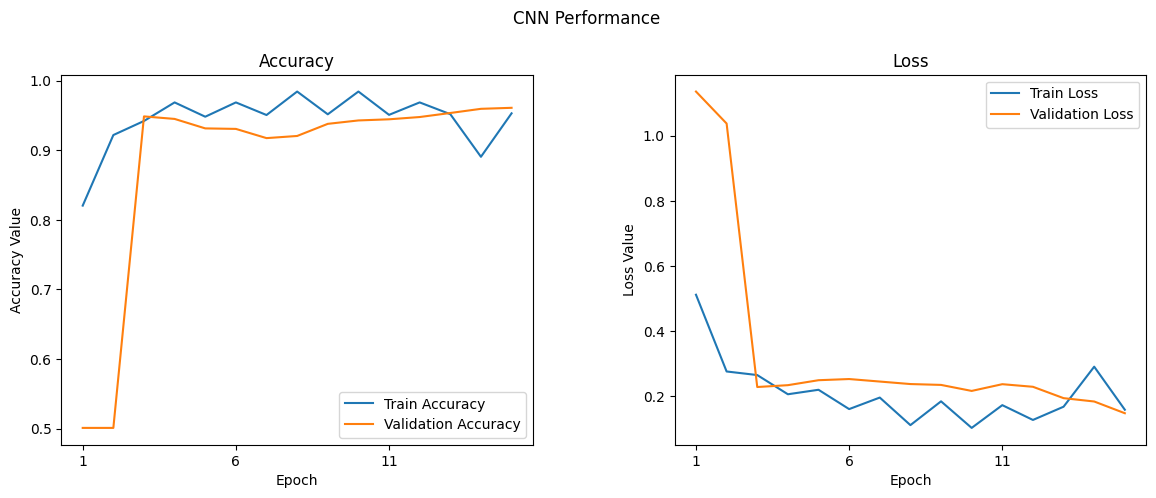

In [20]:
def plot_training_history(results):
    """
    Plot the training and validation accuracy and loss over epochs.

    This function visualizes the model's training progress. It plots two graphs:
    - The first graph shows the training and validation accuracy over epochs.
    - The second graph shows the training and validation loss over epochs.

    Parameters:
    - history: A Keras History object containing the model's training history.

    The function creates a subplot with two axes objects and plots the accuracy and
    loss values stored in the history object.
    """

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('CNN Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(results.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, results.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, results.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")

    # Plot training and validation loss
    ax2.plot(epoch_list, results.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, results.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(results)

### Confusion Matrix

In [21]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_single_column, predicted_classes)
print(conf_matrix)

[[2646  151]
 [  68 2647]]


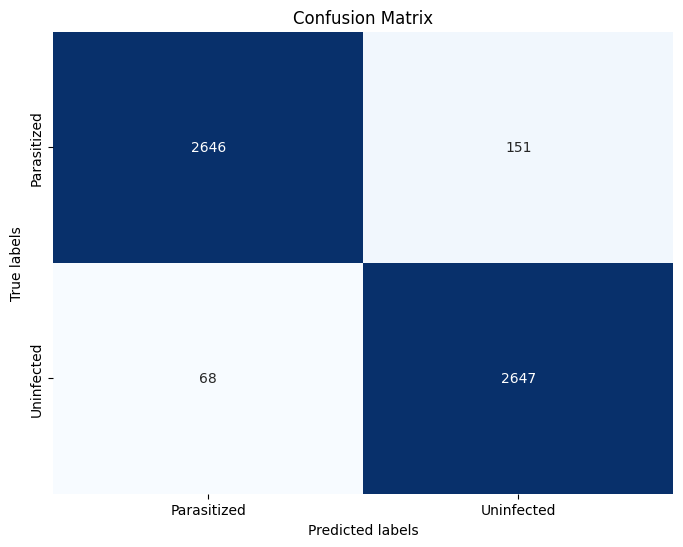

In [22]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()

## Class Activation Mapping (CAM)

In [23]:
_, scipy, Rectangle, peak_local_max = get_gap_test_and_localization_libs()

In [24]:
def load_predicted_images(X_test, predicted_classes, class_idx=0):
    """
    Filters images predicted as a specific class and returns them as an array.

    Parameters:
    - X_test: The test dataset images.
    - predicted_classes: The array of predicted classes for each image in X_test.
    - class_idx: The class index for which to filter images (default is 0).

    Returns:
    - An array of images predicted to be in the specified class.
    """
    predicted_image_idx = np.where(predicted_classes == class_idx)[0]
    predicted_images = np.array([X_test[i] for i in predicted_image_idx])
    return predicted_images

In [25]:
from tensorflow.keras.models import Model
import numpy as np
import scipy.ndimage

def class_activation_map(imgage, model, layer_name='conv2d_7'):
    """
    Generates a class activation heatmap for the given image using the specified model and convolutional layer.

    Parameters:
    - imgage: The input image as a NumPy array (H, W, C).
    - model: The trained Keras model.
    - layer_name: The name of the last convolutional layer in the model to use for CAM.

    Returns:
    - A 2D NumPy array representing the heatmap.
    """
    # Predict the class
    prediction = model.predict(np.expand_dims(imgage, axis=0))
    prediction_class = np.argmax(prediction)

    # Get weights for the final dense layer for the predicted class
    last_layer_weights = model.layers[-1].get_weights()[0]
    last_layer_weights_for_prediction = last_layer_weights[:, prediction_class]

    # Get the output of the specified convolutional layer
    final_conv_layer = model.get_layer(layer_name)
    conv_model = Model(inputs=model.input, outputs=final_conv_layer.output)
    conv_output = conv_model.predict(np.expand_dims(imgage, axis=0))
    conv_output = np.squeeze(conv_output)

    # Resize activation maps to match input image size
    height_ratio = imgage.shape[0] / conv_output.shape[0]
    width_ratio = imgage.shape[1] / conv_output.shape[1]
    upsampled_conv_output = scipy.ndimage.zoom(conv_output, (height_ratio, width_ratio, 1), order=1)

    # Generate the heatmap
    heat_map = np.dot(upsampled_conv_output.reshape((imgage.shape[0] * imgage.shape[1], conv_output.shape[2])),
                      last_layer_weights_for_prediction).reshape(imgage.shape[0], imgage.shape[1])

    # Optional: Mask out black background
    heat_map[imgage[:, :, 0] == 0] = 0

    return heat_map



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


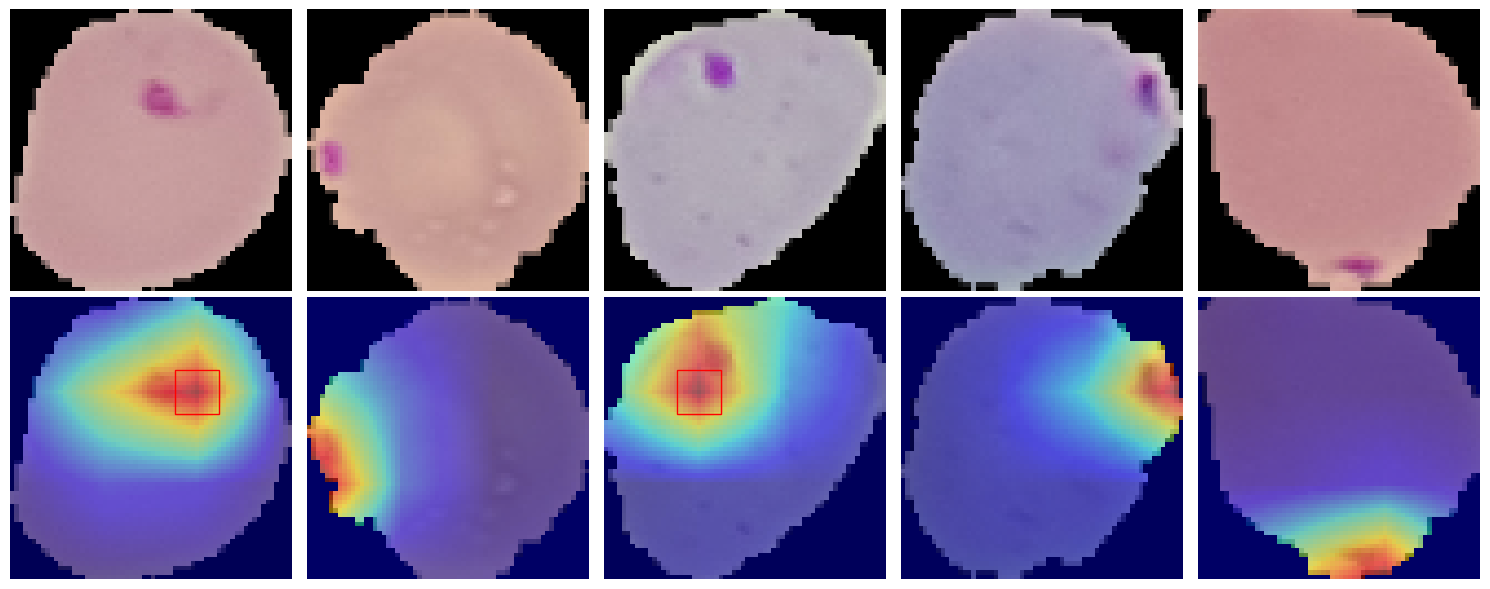

In [26]:
import random

def display_images_with_heatmaps(X_test, predicted_classes, model, layer_name='conv2d_7', save_path='random_heatmap_plots.png'):
    """
    Displays and saves a plot with randomly selected original images of infected cells
    and their corresponding heatmap images, including rectangles around detected peaks.

    Parameters:
    - X_test: The test dataset images.
    - predicted_classes: The array of predicted classes for each image in X_test.
    - model: The trained model to use.
    - layer_name: The name of the last convolutional layer in the model, used for generating heatmaps.
    - save_path: Path where the combined plot will be saved.
    """
    predicted_as_para = load_predicted_images(X_test, predicted_classes, class_idx=0)
    
    # Number of sample images
    num_images = 5
    
    # Randomly select images
    selected_indices = random.sample(range(len(predicted_as_para)), num_images)
    selected_images = [predicted_as_para[i] for i in selected_indices]
    
    fig, axs = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i, imgage in enumerate(selected_images):
        # Generate heatmap for the selected image
        heat_map = class_activation_map(imgage, model, layer_name)
        
        # Detect peaks for rectangle drawing
        peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10)
        
        # Plot original image
        axs[0, i].imshow(imgage.astype('float32'))
        axs[0, i].axis('off')  
        
        # Plot heatmap image
        axs[1, i].imshow(imgage.astype('float32'))
        axs[1, i].imshow(heat_map, cmap='jet', alpha=0.5)  # Overlay heatmap
        for y, x in peak_coords:
            axs[1, i].add_patch(Rectangle((x-5, y-5), 10, 10, linewidth=1, edgecolor='r', facecolor='none'))
        axs[1, i].axis('off')  
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

display_images_with_heatmaps(X_test, predicted_classes, model, layer_name='conv2d_7', save_path='heatmap_plots.png')
